In [56]:
import pandas as pd
import lightgbm as lgb
import numpy
import shap
from sklearn.metrics import accuracy_score

In [57]:

# Step 1: Load train and test data
train_path = "../../data/processed/train_data.csv"  # Replace with your train file path
test_path = "../../data/processed/test_data.csv"    # Replace with your test file path

# Assuming the target column is named 'target'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Split features and target
X_train = train_data.drop(columns=["target"])  # Replace "target" with the actual name
y_train = train_data["target"]

X_test = test_data.drop(columns=["target"])
y_test = test_data["target"]


In [58]:
# Step 2: Train an initial LightGBM model
lgbm_model = lgb.LGBMClassifier(objective="binary", random_state=42)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 416, number of negative: 430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191497
[LightGBM] [Info] Number of data points in the train set: 846, number of used features: 754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491726 -> initscore=-0.033100
[LightGBM] [Info] Start training from score -0.033100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(objective='binary', random_state=42)

In [59]:
# Step 3: Compute SHAP values
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_train)[1]  # For binary classification, class 1

C:\Users\unknow\Desktop\IASD S1\Parkinson_disease_classification\venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [60]:
# Calculate mean absolute SHAP values
mean_shap_values = abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean_SHAP_Value': mean_shap_values
}).sort_values(by='Mean_SHAP_Value', ascending=False)

print("Top Features by SHAP Importance:\n", shap_importance)

Top Features by SHAP Importance:
                        Feature  Mean_SHAP_Value
753  tqwt_kurtosisValue_dec_36         0.020198
0                           id         0.020198
737  tqwt_kurtosisValue_dec_20         0.020198
736  tqwt_kurtosisValue_dec_19         0.020198
735  tqwt_kurtosisValue_dec_18         0.020198
..                         ...              ...
6             numPeriodsPulses         0.020198
5                    numPulses         0.020198
4                         RPDE         0.020198
3                          DFA         0.020198
2                          PPE         0.020198

[754 rows x 2 columns]


C:\Users\unknow\Desktop\IASD S1\Parkinson_disease_classification\venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


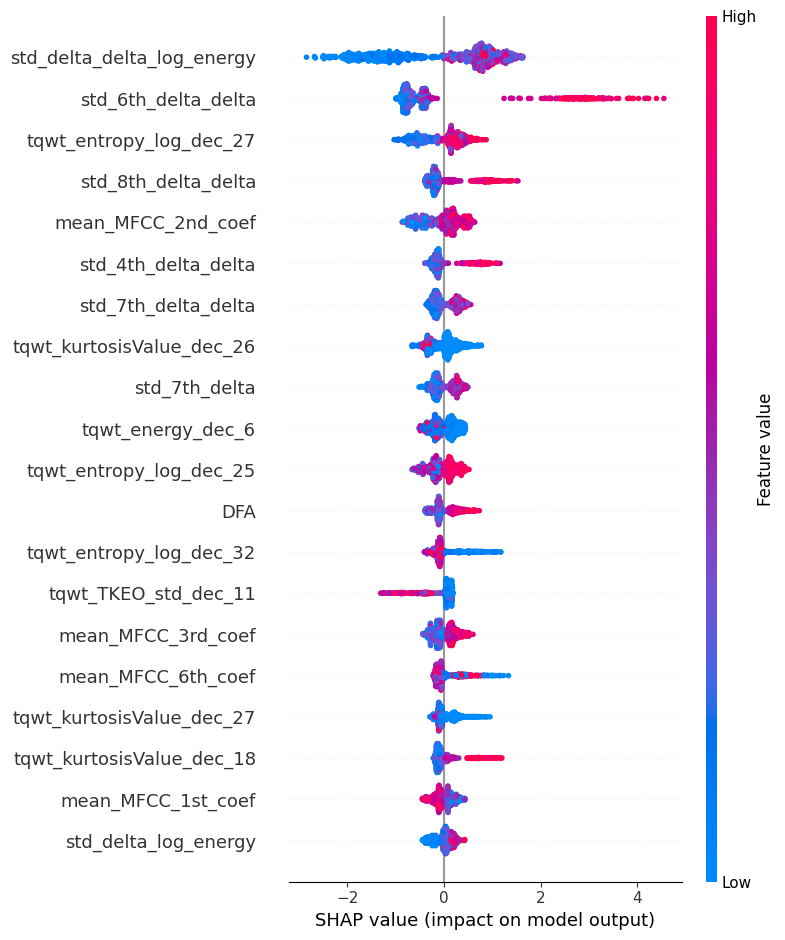

In [61]:
# Visualize combined SHAP values

# Compute SHAP values (directly returns a 2D array for binary classification)
shap_values = explainer.shap_values(X_train)  # Returns a single array for binary classification

# Plot SHAP summary
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

In [62]:
# Step 4: Select top features based on SHAP
top_n = 100  # Adjust this number based on your analysis
selected_features = shap_importance['Feature'].iloc[:top_n].tolist()

In [63]:
# Filter datasets to only use selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [64]:
# Step 5: Retrain LightGBM with selected features
lgbm_model_selected = lgb.LGBMClassifier(objective="binary", random_state=42)
lgbm_model_selected.fit(X_train_selected, y_train)

[LightGBM] [Info] Number of positive: 416, number of negative: 430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25238
[LightGBM] [Info] Number of data points in the train set: 846, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491726 -> initscore=-0.033100
[LightGBM] [Info] Start training from score -0.033100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(objective='binary', random_state=42)

In [65]:
# Step 6: Evaluate the final model
y_pred = lgbm_model_selected.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print("\nFinal Model Accuracy with Selected Features:", accuracy)


Final Model Accuracy with Selected Features: 0.9574468085106383
